In [35]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy import stats
from scipy.signal import butter, welch, filtfilt, resample
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [16]:
def LOSOCV(Data,X,y,groups,models,LOin=0,balance=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1.5*len(indsp)),replace=True)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
            
            print('rows with symptom = %d/%d'%(sum(ytr==1),len(ytr)))

            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [17]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [18]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
path = r'Y:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
dict_path = 'Y:\CIS-PD Study\Data_dict' #remote repo
# dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

scores_path = r'Y:\CIS-PD Study\Scores' #remote repo
# scores_path = '../Scores/' #local path

#path where feature matrix is saved
# features_path = '../FeatureMatrix' #local
features_path = 'Y:\CIS-PD Study\FeatureMatrix'

## Load unpacked features data

In [73]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
filename = 'Features_AllLocsHP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [74]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [75]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [76]:
# #drop features 
# Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
# Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [77]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [78]:
Dataorig = Data.copy()
Data.shape

(40377, 63)

In [79]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

In [80]:
s = 1004
Data.loc[Data.Subject==s,'Visit'].unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

## LOSO CV - ALL TASKS

## Bradykinesia

In [40]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [41]:
Dataorig = Data.copy()

In [42]:
Dataorig[symptom].unique()

array([  0.,   1.,  nan,   2.,   3.,   4.])

In [43]:
Data[symptom].unique()

array([  0.,   1.,  nan,   2.,   3.,   4.])

In [44]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/32368 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.544, rec=0.570, Spec=0.761, auroc_train=1.000, auroc=0.732

Subj/Visit 1, prec=0.952, rec=0.760, Spec=0.589, auroc_train=1.000, auroc=0.765

Subj/Visit 2, prec=0.775, rec=0.754, Spec=0.712, auroc_train=1.000, auroc=0.797

Subj/Visit 3, prec=0.476, rec=0.942, Spec=0.586, auroc_train=1.000, auroc=0.855

Subj/Visit 4, prec=0.791, rec=0.611, Spec=0.730, auroc_train=1.000, auroc=0.749

Subj/Visit 5, prec=0.620, rec=0.653, Spec=0.428, auroc_train=1.000, auroc=0.550

Subj/Visit 6, prec=0.642, rec=0.796, Spec=0.585, auroc_train=1.000, auroc=0.784

Subj/Visit 7, prec=0.872, rec=0.666, Spec=0.396, auroc_train=1.000, auroc=0.549

Subj/Visit 8, prec=0.332, rec=0.585, Spec=0.544, auroc_train=1.000, auroc=0.584

Subj/Visit 9, prec=0.657, rec=0.817, Spec=0.582, auroc_train=1.000, auroc=0.777

Subj/Visit 10, prec=0.595, rec=0.547, Spec=0.732, auroc_train=1.000, auroc=0.709

Subj/Visit 11, prec=0.291, rec=0.780, Spec=0.

In [45]:
resultsbrady = res_group['Random Forest']['auroc']

In [48]:
np.save('./Results/resultsbradyLOSO.npy',resultsbrady)

In [46]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

Removing nans

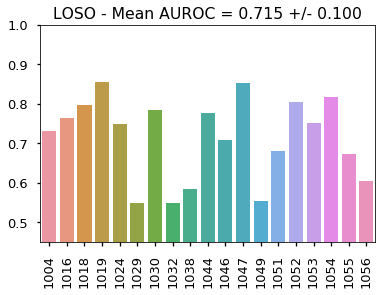

In [47]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Tremor

In [56]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8879/38405 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.366, rec=0.340, Spec=0.936, auroc_train=1.000, auroc=0.818

Subj/Visit 1, prec=0.748, rec=0.107, Spec=0.970, auroc_train=1.000, auroc=0.762

Subj/Visit 2, prec=0.632, rec=0.321, Spec=0.981, auroc_train=1.000, auroc=0.824

Subj/Visit 3, prec=0.156, rec=0.355, Spec=0.911, auroc_train=1.000, auroc=0.720

Subj/Visit 4, prec=0.511, rec=0.080, Spec=0.973, auroc_train=1.000, auroc=0.675

Subj/Visit 5, prec=0.681, rec=0.376, Spec=0.883, auroc_train=1.000, auroc=0.742

Subj/Visit 6, prec=0.824, rec=0.455, Spec=0.994, auroc_train=1.000, auroc=0.915

Subj/Visit 7, prec=0.611, rec=0.317, Spec=0.992, auroc_train=1.000, auroc=0.912

Subj/Visit 8, prec=0.953, rec=0.302, Spec=0.981, auroc_train=1.000, auroc=0.785

Subj/Visit 9, prec=0.181, rec=0.338, Spec=0.942, auroc_train=1.000, auroc=0.897

Subj/Visit 10, prec=0.612, rec=0.234, Spec=0.962, auroc_train=1.000, auroc=0.710

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.991, au

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.973, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.048, rec=0.250, Spec=0.966, auroc_train=1.000, auroc=0.911

Subj/Visit 17, prec=0.939, rec=0.155, Spec=0.956, auroc_train=1.000, auroc=0.600

Subj/Visit 18, prec=0.925, rec=0.334, Spec=0.919, auroc_train=1.000, auroc=0.703
f1_test=0.290+/-0.187, prec=0.481+/-0.335, rec=0.263+/-0.141, auprc=0.442+/-0.293, auroc=0.782+/-0.091
Elapsed time = 4.940 min


In [58]:
resultstremor = res_group['Random Forest']['auroc']

In [59]:
np.save('./Results/resultstremorLOSO.npy',resultstremor)

Removing nans

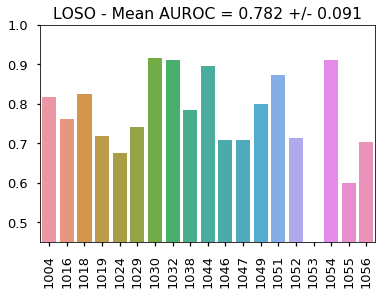

In [13]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [42]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.794, rec=0.222, Spec=0.548, auroc_train=1.000, auroc=0.474

Subj/Visit 1, prec=0.281, rec=0.257, Spec=0.876, auroc_train=1.000, auroc=0.671

Subj/Visit 2, prec=0.478, rec=0.458, Spec=0.940, auroc_train=1.000, auroc=0.908

Subj/Visit 3, prec=0.589, rec=0.644, Spec=0.727, auroc_train=1.000, auroc=0.766

Subj/Visit 4, prec=0.442, rec=0.885, Spec=0.849, auroc_train=1.000, auroc=0.884

Subj/Visit 5, prec=0.688, rec=0.478, Spec=0.943, auroc_train=1.000, auroc=0.900

Subj/Visit 6, prec=0.564, rec=0.595, Spec=0.762, auroc_train=1.000, auroc=0.770
f1_test=0.490+/-0.125, prec=0.548+/-0.155, rec=0.506+/-0.212, auprc=0.549+/-0.202, auroc=0.768+/-0.144
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.984, rec=0.984, Spec=0.714, auroc_train=1.000, auroc=0.976

Subj/Visit 1, prec=0.955, rec=1.000, Spec=0.633, auroc_train=1.000, auroc=0.991

Subj/Visit 2, prec=0.945, rec=1.000, Spec=0.536, auroc_train=1.000, auroc=0.992

Subj/Visit 3, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.791, rec=0.738, Spec=0.768, auroc_train=1.000, auroc=0.821

Subj/Visit 1, prec=0.842, rec=0.830, Spec=0.812, auroc_train=1.000, auroc=0.857

Subj/Visit 2, prec=0.801, rec=0.842, Spec=0.746, auroc_train=1.000, auroc=0.885

Subj/Visit 3, prec=0.901, rec=0.694, Spec=0.904, auroc_train=1.000, auroc=0.882

Subj/Visit 4, prec=0.822, rec=0.811, Spec=0.793, auroc_train=1.000, auroc=0.889

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.805

Subj/Visit 6, prec=0.472, rec=0.482, Spec=0.469, auroc_train=1.000, auroc=0.467
f1_test=0.752+/-0.115, prec=0.773+/-0.128, rec=0.735+/-0.115, auprc=0.829+/-0.134, auroc=0.801+/-0.140
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.8

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.963+/-0.031, prec=0.935+/-0.057, rec=0.994+/-0.009, auprc=0.989+/-0.012, auroc=0.935+/-0.040


In [50]:
resultsbrady_pers=res_all.auroc.values
np.save('./Results/resultsbradyPERS.npy',resultsbrady_pers)

In [51]:
Data.shape

(32368, 63)

In [46]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

(0.45, 1)

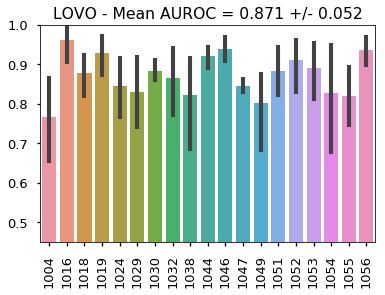

In [48]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [64]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models,balance=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest
rows with symptom = 30/75

Subj/Visit 0, prec=0.853, rec=0.184, Spec=0.968, auroc_train=1.000, auroc=0.636
rows with symptom = 188/470


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.892, auroc_train=1.000, auroc=nan
rows with symptom = 188/470


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.926, auroc_train=1.000, auroc=nan
rows with symptom = 175/437

Subj/Visit 3, prec=0.241, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.994
rows with symptom = 188/470


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan
rows with symptom = 188/470


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.905, auroc_train=1.000, auroc=nan
rows with symptom = 171/427

Subj/Visit 6, prec=0.158, rec=0.353, Spec=0.880, auroc_train=1.000, auroc=0.759
f1_test=0.130+/-0.157, prec=0.179+/-0.289, rec=0.219+/-0.342, auprc=0.631+/-0.282, auroc=0.797+/-0.149
Subject 1016
Training Random Forest
rows with symptom = 855/2137

Subj/Visit 0, prec=0.810, rec=0.804, Spec=0.826, auroc_train=1.000, auroc=0.911
rows with symptom = 831/2077

Subj/Visit 1, prec=0.864, rec=0.890, Spec=0.834, auroc_train=1.000, auroc=0.937
rows with symptom = 840/2100

Subj/Visit 2, prec=0.896, rec=0.847, Spec=0.887, auroc_train=1.000, auroc=0.946
rows with symptom = 836/2090

Subj/Visit 3, prec=0.898, rec=0.898, Spec=0.894, auroc_train=1.000, auroc=0.956
rows with symptom = 840/2100

Subj/Visit 4, prec=0.932, rec=0.920, Spec=0.919, auroc_train=1.000, auroc=0.970
rows with symptom = 813/2033

Subj/Visit 5, prec=0.883, rec=0.874, Spe

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.469, auroc_train=1.000, auroc=nan
f1_test=0.751+/-0.308, prec=0.755+/-0.310, rec=0.747+/-0.307, auprc=0.943+/-0.027, auroc=0.944+/-0.018
Subject 1018
Training Random Forest
rows with symptom = 124/310

Subj/Visit 0, prec=0.810, rec=0.270, Spec=0.983, auroc_train=1.000, auroc=0.822
rows with symptom = 179/447

Subj/Visit 1, prec=0.200, rec=1.000, Spec=0.880, auroc_train=1.000, auroc=0.998
rows with symptom = 176/440

Subj/Visit 2, prec=0.200, rec=1.000, Spec=0.831, auroc_train=1.000, auroc=0.996
rows with symptom = 150/375

Subj/Visit 3, prec=0.515, rec=0.459, Spec=0.932, auroc_train=1.000, auroc=0.891
rows with symptom = 144/360

Subj/Visit 4, prec=0.476, rec=0.465, Spec=0.917, auroc_train=1.000, auroc=0.843
rows with symptom = 175/437

Subj/Visit 5, prec=0.203, rec=1.000, Spec=0.841, auroc_train=1.000, auroc=0.983
rows with symptom = 174/435

Subj/Visit 6, prec=0.265, rec=1.000, Spec=0.87

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.950, auroc_train=1.000, auroc=nan
rows with symptom = 12/30
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=nan
rows with symptom = 6/15

Subj/Visit 3, prec=0.128, rec=1.000, Spec=0.833, auroc_train=1.000, auroc=0.994
rows with symptom = 12/30
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.966, auroc_train=1.000, auroc=nan
rows with symptom = 12/30


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.966, auroc_train=1.000, auroc=nan
f1_test=0.125+/-0.197, prec=0.085+/-0.142, rec=0.306+/-0.435, auprc=0.820+/-0.029, auroc=0.992+/-0.002
Subject 1049
Training Random Forest
rows with symptom = 796/1990

Subj/Visit 0, prec=0.841, rec=0.793, Spec=0.782, auroc_train=1.000, auroc=0.871
rows with symptom = 875/2187

Subj/Visit 1, prec=0.750, rec=0.851, Spec=0.784, auroc_train=1.000, auroc=0.887
rows with symptom = 869/2173

Subj/Visit 2, prec=0.697, rec=0.886, Spec=0.724, auroc_train=1.000, auroc=0.905
rows with symptom = 897/2243

Subj/Visit 3, prec=0.831, rec=0.438, Spec=0.956, auroc_train=1.000, auroc=0.878
rows with symptom = 906/2265

Subj/Visit 4, prec=0.783, rec=0.874, Spec=0.896, auroc_train=1.000, auroc=0.947
rows with symptom = 871/2177

Subj/Visit 5, prec=0.769, rec=0.725, Spec=0.831, auroc_train=1.000, auroc=0.868
rows with symptom = 840/2100

Subj/Visit 6, prec=0.739, rec=0.769, Sp

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.901, auroc_train=1.000, auroc=nan
rows with symptom = 6/15
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan
rows with symptom = 6/15
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.914, auroc_train=1.000, auroc=nan
rows with symptom = 6/15


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan
rows with symptom = 0/0
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest
rows with symptom = 30/75

Subj/Visit 0, prec=0.515, rec=0.372, Spec=0.853, auroc_train=1.000, auroc=0.644
rows with symptom = 124/310
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.791, auroc_train=1.000, auroc=nan
rows with symptom = 124/310


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.864, auroc_train=1.000, auroc=nan
rows with symptom = 94/235

Subj/Visit 3, prec=0.187, rec=0.667, Spec=0.670, auroc_train=1.000, auroc=0.790
rows with symptom = 124/310
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.816, auroc_train=1.000, auroc=nan
rows with symptom = 124/310


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.889, auroc_train=1.000, auroc=nan
f1_test=0.121+/-0.175, prec=0.117+/-0.191, rec=0.173+/-0.259, auprc=0.381+/-0.104, auroc=0.717+/-0.073
Subject 1053
Training Random Forest
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 0/0
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
rows with symptom = 0/0
only 1 class available in train data - skipping
rows with symptom = 12/30
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.966, auroc_train=1.000, auroc=nan
rows with symptom = 12/30
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.978, auroc_train=1.000, auroc=nan
rows with symptom = 12/30
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:103: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:110: RuntimeWarning: Mean of empty slice



Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest
rows with symptom = 1049/2623

Subj/Visit 0, prec=0.951, rec=0.947, Spec=0.000, auroc_train=1.000, auroc=0.654
rows with symptom = 1131/2827

Subj/Visit 1, prec=0.601, rec=0.896, Spec=0.102, auroc_train=1.000, auroc=0.547
rows with symptom = 1117/2793

Subj/Visit 2, prec=0.687, rec=0.955, Spec=0.181, auroc_train=1.000, auroc=0.647
rows with symptom = 1055/2637

Subj/Visit 3, prec=0.961, rec=0.929, Spec=0.667, auroc_train=1.000, auroc=0.915
rows with symptom = 1078/2695

Subj/Visit 4, prec=0.824, rec=0.972, Spec=0.167, auroc_train=1.000, auroc=0.718
rows with symptom = 1040/2600

Subj/Visit 5, prec=0.991, rec=0.858, Spec=0.000, auroc_train=1.000, auroc=0.632
f1_test=0.871+/-0.084, prec=0.836+/-0.147, rec=0.926+/-0.039, auprc=0.890+/-0.118, auroc=0.685+/-0.114
Subject 1056
Training

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.899, rec=0.896, Spec=0.205, auroc_train=1.000, auroc=0.633
f1_test=0.785+/-0.175, prec=0.765+/-0.272, rec=0.886+/-0.052, auprc=0.821+/-0.220, auroc=0.712+/-0.081


In [14]:
resultstremor_pers=res_all.auroc.values
np.save('./Results/resultstremorPERS.npy',resultstremor_pers)

In [54]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.45, 1.0)

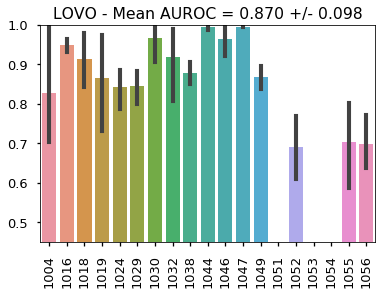

In [70]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

(0.45, 1.0)

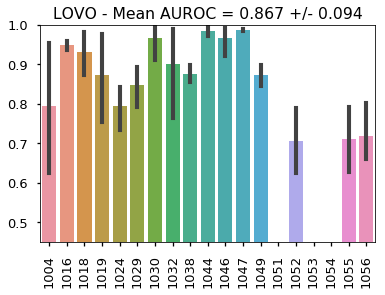

In [55]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

## Box plots comparing global and personal

In [14]:
resultstremor = np.load('./Results/resultstremorLOSO.npy')
resultsbrady = np.load('./Results/resultsbradyLOSO.npy')

In [15]:
resultsbrady_pers=np.load('./Results/resultsbradyPERS.npy')
resultstremor_pers=np.load('./Results/resultstremorPERS.npy')

In [16]:
len(resultstremor)

19

In [17]:
results = pd.DataFrame({'Population-Bradykinesia':resultsbrady, 'Personal-Bradykinesia':resultsbrady_pers,
             'Population-Tremor':resultstremor, 'Personal-Tremor':resultstremor_pers})

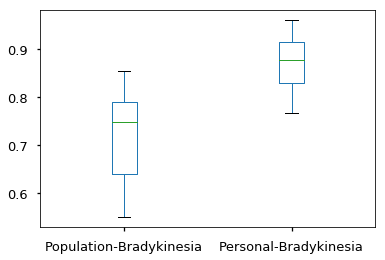

In [18]:
results[['Population-Bradykinesia','Personal-Bradykinesia']].plot(kind='box')

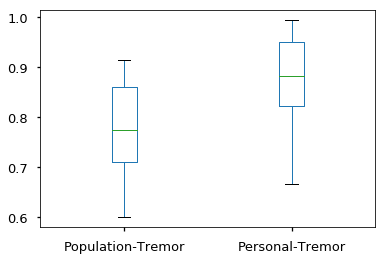

In [19]:
results[['Population-Tremor','Personal-Tremor']].plot(kind='box')

In [ ]:
results['Personal-Tremor'].std()

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

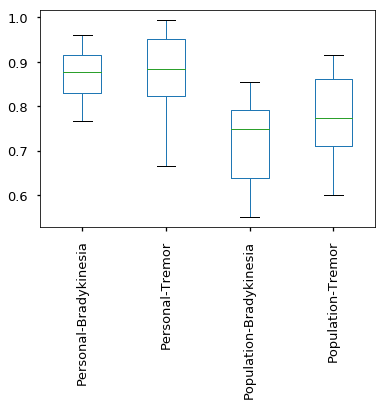

In [23]:
results.plot(kind='box')
plt.xticks(rotation=90)

In [26]:
from scipy import stats

In [41]:
stats.ttest_rel(results['Personal-Bradykinesia'].values,results['Population-Bradykinesia'].values)

Ttest_relResult(statistic=6.7761034917453715, pvalue=2.3928902074411252e-06)

In [39]:
results['Personal-Tremor']

0     0.789604
1     0.945532
2     0.922093
3     0.872331
4     0.832880
5     0.834678
6     0.966710
7     0.914523
8     0.878114
9     0.995063
10    0.966727
11    0.991447
12    0.887439
13         NaN
14    0.717673
15         NaN
16         NaN
17    0.666163
18    0.709289
Name: Personal-Tremor, dtype: float64

In [38]:
results['Population-Tremor']

0     0.817951
1     0.762198
2     0.823991
3     0.719815
4     0.675224
5     0.741891
6     0.915046
7     0.912006
8     0.785081
9     0.896676
10    0.709513
11    0.707417
12    0.800534
13    0.872246
14    0.714700
15         NaN
16    0.910725
17    0.599593
18    0.703462
Name: Population-Tremor, dtype: float64

In [40]:
stats.ttest_rel(results['Personal-Tremor'][~results['Personal-Tremor'].isnull()].values,
                results['Population-Tremor'][~results['Personal-Tremor'].isnull()].values)

Ttest_relResult(statistic=4.4940925653233457, pvalue=0.00042831179045540416)

In [48]:
from scipy.stats import iqr
print(iqr(results['Population-Tremor'][~results['Population-Tremor'].isnull()].values))
print(iqr(results['Personal-Tremor'][~results['Personal-Tremor'].isnull()].values))

0.149372213578
0.128765179321


## Evaluate performance of global models on Subtasks (this section has to be rewritten to train global and personal models on all tasks and analyze performance on each subset of tasks)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Tremor 1333/3187 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.757, rec=0.812, Spec=0.926, auroc_train=1.000, auroc=0.923

Subj/Visit 1, prec=0.768, rec=0.495, Spec=0.698, auroc_train=1.000, auroc=0.648

Subj/Visit 2, prec=0.802, rec=0.901, Spec=0.778, auroc_train=1.000, auroc=0.930

Subj/Visit 3, prec=0.562, rec=0.800, Spec=0.776, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.775, rec=0.392, Spec=0.892, auroc_train=1.000, auroc=0.683

Subj/Visit 5, prec=0.717, rec=0.804, Spec=0.460, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=0.949, rec=0.825, Spec=0.922, auroc_train=1.000, auroc=0.939

Subj/Visit 7, prec=0.521, rec=0.700, Spec=0.408, auroc_train=1.000, auroc=0.566

Subj/Visit 8, prec=0.894, rec=0.596, Spec=0.389, auroc_train=1.000, auroc=0.405

Subj/Visit 9, prec=0.758, rec=0.625, Spec=0.830, auroc_train=1.000, auroc=0.838

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.0

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.286, rec=0.833, Spec=0.781, auroc_train=1.000, auroc=0.875

Subj/Visit 17, prec=1.000, rec=0.328, Spec=1.000, auroc_train=1.000, auroc=0.751

Subj/Visit 18, prec=0.979, rec=0.354, Spec=0.958, auroc_train=1.000, auroc=0.747
f1_test=0.504+/-0.281, prec=0.570+/-0.336, rec=0.512+/-0.297, auprc=0.631+/-0.302, auroc=0.750+/-0.150

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Tremor 895/6673 = 0.13
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.124


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.322, Spec=1.000, auroc_train=1.000, auroc=0.945


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.631, rec=0.745, Spec=0.932, auroc_train=1.000, auroc=0.950


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.804

Subj/Visit 18, prec=0.992, rec=0.510, Spec=0.987, auroc_train=1.000, auroc=0.799
f1_test=0.099+/-0.226, prec=0.191+/-0.376, rec=0.084+/-0.203, auprc=0.678+/-0.362, auroc=0.709+/-0.282

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Tremor 3714/12167 = 0.31
Training Random Forest

Subj/Visit 0, prec=0.421, rec=0.232, Spec=0.935, auroc_train=1.000, auroc=0.707

Subj/Visit 1, prec=0.894, rec=0.063, Spec=0.952, auroc_train=1.000, auroc=0.531

Subj/Visit 2, prec=0.167, rec=0.087, Spec=0.938, auroc_train=1.000, auroc=0.555

Subj/Visit 3, prec=0.028, rec=0.042, Spec=0.948, auroc_train=1.000, auroc=0.509

Subj/Visit 4, prec=0.569, rec=0.120, Spec=0.947, auroc_train=1.000, auroc=0.587

Subj/Visit 5, prec=0.744, rec=0.450, Spec=0.780

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=1.000, rec=0.237, Spec=1.000, auroc_train=1.000, auroc=0.731


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.930, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.504


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.691, rec=0.506, Spec=0.748, auroc_train=1.000, auroc=0.672


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.913, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.365, rec=0.342, Spec=0.909, auroc_train=1.000, auroc=0.728


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.957, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.176, Spec=0.821, auroc_train=1.000, auroc=0.430

Subj/Visit 18, prec=0.879, rec=0.269, Spec=0.867, auroc_train=1.000, auroc=0.624
f1_test=0.176+/-0.199, prec=0.348+/-0.376, rec=0.133+/-0.159, auprc=0.481+/-0.343, auroc=0.569+/-0.151

 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Tremor 2227/10303 = 0.22
Training Random Forest

Subj/Visit 0, prec=0.241, rec=0.140, Spec=0.955, auroc_train=1.000, auroc=0.782

Subj/Visit 1, prec=0.905, rec=0.083, Spec=0.994, auroc_train=1.000, auroc=0.805

Subj/Visit 2, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.823


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.364, rec=0.019, Spec=0.982, auroc_train=1.000, auroc=0.667

Subj/Visit 5, prec=0.658, rec=0.200, Spec=0.922, auroc_train=1.000, auroc=0.676


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.807

Subj/Visit 8, prec=0.963, rec=0.270, Spec=0.980, auroc_train=1.000, auroc=0.845


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=0.418


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.699, rec=0.657, Spec=0.768, auroc_train=1.000, auroc=0.777


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.133, rec=0.051, Spec=0.967, auroc_train=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.968, rec=0.276, Spec=0.975, auroc_train=1.000, auroc=0.789

Subj/Visit 18, prec=0.915, rec=0.328, Spec=0.942, auroc_train=1.000, auroc=0.780
f1_test=0.153+/-0.204, prec=0.360+/-0.409, rec=0.111+/-0.167, auprc=0.501+/-0.320, auroc=0.730+/-0.119


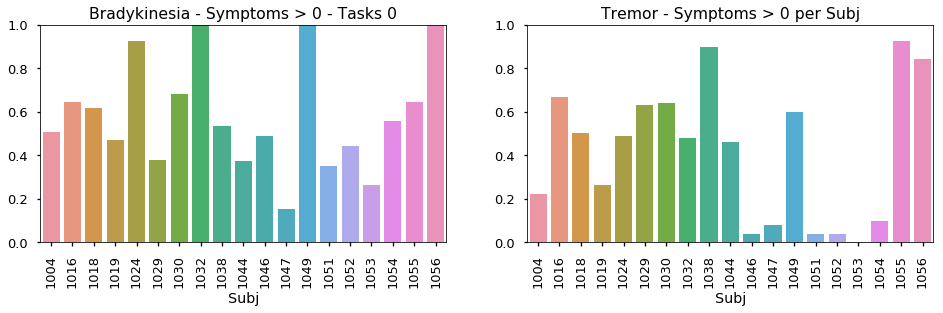

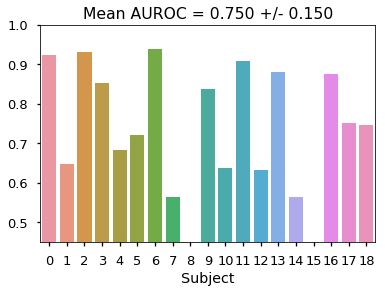

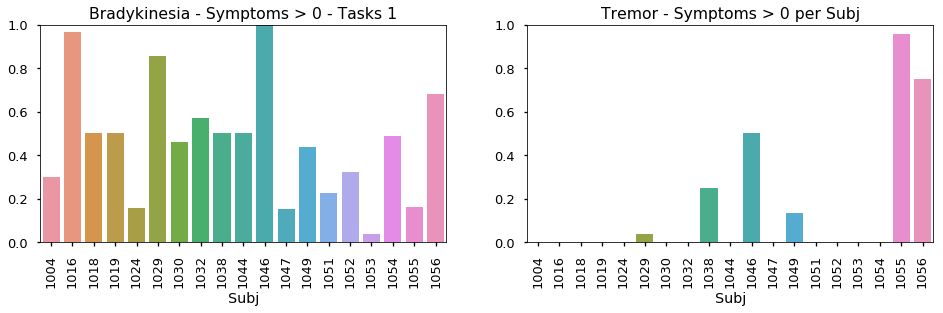

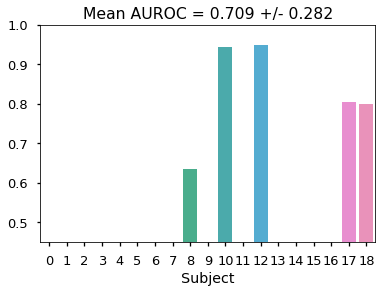

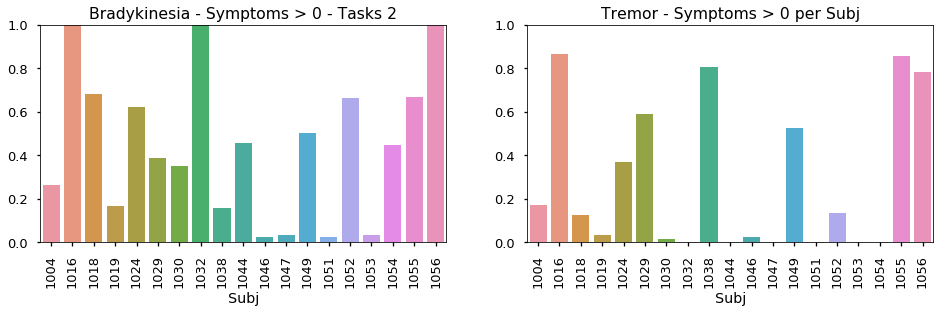

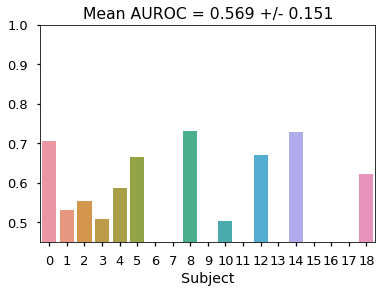

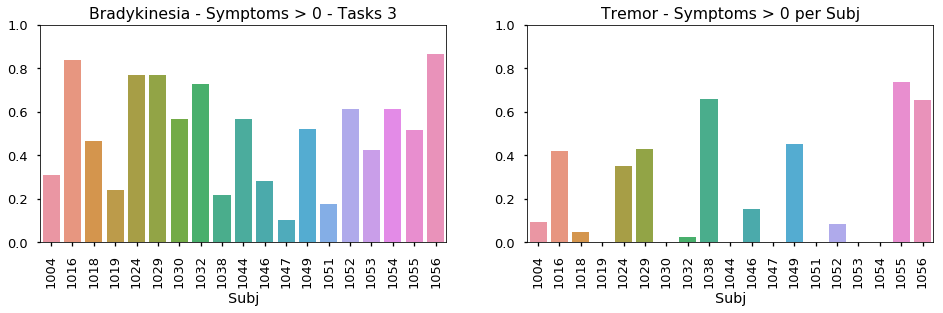

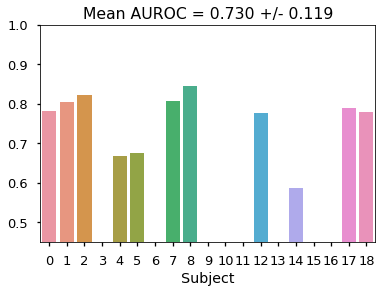

In [146]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on each subject
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


# Effect of # of subjects

In [132]:
# #if want to use only the selected features (to speed up)
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

### Bradykinesia

In [211]:
symptom = 'Bradykinesia'
# symptom = 'Tremor'
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index
Dataorig = Data.copy()

In [212]:
symptom

'Bradykinesia'

In [213]:
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
Data=pd.DataFrame()
for t in taskA:
    Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))  

In [214]:
Data.Task.unique()

array(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'], dtype=object)

In [378]:
#sample p subjects at random for train and test on 1 random remaining subject

results = pd.DataFrame()
subjs=Data.Subject.unique()
nsubj = [2,3,4]#,6,8,12,16] #of subjects to train on
clf = RandomForestClassifier(n_estimators=50,random_state=2)
auc_all={}
testsublist = []
trainsublist = []
t1=time.time()

for iteration in range(500):
    

    trainsubjall = np.random.choice(subjs,size=4,replace=False) #sample 16 subjects at random
    
    #pick a test subject at random
    losubjs = Data[~Data.Subject.isin(trainsubjall)].Subject.unique()
    testsubj = np.random.choice(losubjs)
    dtest = Data[Data.Subject==testsubj]
    testsublist.append(testsubj)
    
    #use top features
    Xte = dtest.iloc[:,7:].as_matrix()
#     Xte = dtest[topf].as_matrix()
    yte = (dtest[symptom]>0).values.astype(int)

#     if iteration%10==0:
#         print(iteration,trainsubjall,testsubj)

    #compute and store AUC for an incremental number of train subjects tested on the left out subject
    for NS in nsubj:
    
        trainsubj = trainsubjall[:NS] #add subjects incrementally each time
        dtrain = Data[Data.Subject.isin(trainsubj)]

        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
    
        print(iteration,trainsubj,testsubj)
        
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auc_all.update({NS:auroc}) #store auc for each grp

    trainsublist.append(trainsubj)
    results=pd.concat((results,pd.DataFrame(auc_all,index=[iteration])))
    


#     results.update({ng:auc_all}) #save auc for all runs for each group
print('elapsed %.3f min'%((time.time()-t1)/60))


0 [1054 1038] 1051
0 [1054 1038 1053] 1051
0 [1054 1038 1053 1024] 1051
1 [1029 1054] 1018
1 [1029 1054 1052] 1018
1 [1029 1054 1052 1051] 1018
2 [1055 1056] 1030
2 [1055 1056 1049] 1030
2 [1055 1056 1049 1052] 1030
3 [1056 1047] 1052
3 [1056 1047 1053] 1052
3 [1056 1047 1053 1055] 1052
4 [1052 1055] 1046
4 [1052 1055 1044] 1046
4 [1052 1055 1044 1019] 1046
5 [1004 1029] 1055
5 [1004 1029 1051] 1055
5 [1004 1029 1051 1016] 1055
6 [1038 1046] 1047
6 [1038 1046 1032] 1047
6 [1038 1046 1032 1016] 1047
7 [1044 1024] 1049
only 1 class in test data - cannot compute roc curve
7 [1044 1024 1054] 1049
only 1 class in test data - cannot compute roc curve
7 [1044 1024 1054 1030] 1049
only 1 class in test data - cannot compute roc curve
8 [1016 1054] 1024
8 [1016 1054 1018] 1024
8 [1016 1054 1018 1052] 1024
9 [1004 1019] 1046
9 [1004 1019 1056] 1046
9 [1004 1019 1056 1049] 1046
10 [1004 1032] 1056
only 1 class in test data - cannot compute roc curve
10 [1004 1032 1054] 1056
only 1 class in test da

In [73]:
results.to_csv('SimsMultiSubj234_Tremor.csv')

In [170]:
results.to_csv('SimsMultiSubj_Brady.csv')

In [47]:
np.save('SimsMultiSubj_testsublist_tremor234.npy',testsublist)

Train subj analysis

In [381]:
results2=results.iloc[:,1:].copy()

In [382]:
baseline = results.iloc[:,0].copy()

In [383]:
diffs = results2.apply(lambda x:x - baseline)

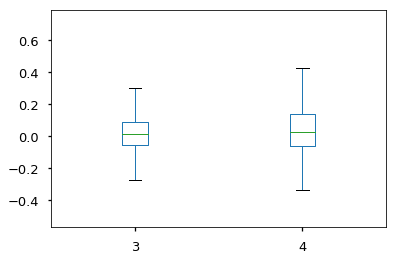

In [384]:
diffs.plot(kind='box')

Explore correlation between AUC impro and train/test subj combination

In [385]:
trainsublist=np.asarray(trainsublist)

In [386]:
testsublist=np.asarray(testsublist)

In [387]:
diffs['trainsub']=trainsublist[:,2]
diffs['testsub']=testsublist

In [388]:
diffs2=diffs[[3,'trainsub','testsub']]

In [389]:
diffs2.head()

,3,trainsub,testsub
0,-0.176688,1053,1051
1,0.049839,1052,1018
2,0.229883,1049,1030
3,0.124573,1053,1052
4,-0.130081,1044,1046


In [409]:
np.sort(diffs2.testsub.unique())

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [390]:
tr = diffs2.trainsub.values
te = diffs2.testsub.values

In [391]:
AUCheatmap = pd.DataFrame(data=np.nan*np.ones((19,19)),columns=[np.sort(diffs2.testsub.unique())])
AUCheatmap.index=np.unique(diffs2.trainsub.values)

In [407]:
AUCheatmap.head()

,1004,1016,1018,1019,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056
1004,NaN,0.043519,NaN,0.018333,NaN,-0.124263,-0.017254,NaN,0.177818,0.017713,0.027361,0.351913,NaN,-0.120792,0.088616,NaN,0.217347,0.064956,NaN
1016,0.115210,NaN,-0.109597,NaN,NaN,0.206368,-0.146295,NaN,-0.084163,-0.030910,-0.041588,-0.043877,NaN,0.001080,0.208533,-0.055972,-0.124235,0.055695,NaN
1018,0.030788,NaN,NaN,NaN,0.197035,-0.133771,NaN,NaN,NaN,0.344460,-0.059099,-0.077583,NaN,0.035554,-0.057541,0.279028,-0.020536,NaN,NaN
1019,0.168906,NaN,0.419758,NaN,0.299444,0.455926,-0.054806,NaN,0.089672,0.175582,NaN,0.156362,NaN,0.080378,NaN,0.164306,0.122066,NaN,NaN
1024,NaN,NaN,-0.072823,-0.064722,NaN,0.008034,-0.192910,NaN,0.249900,-0.020819,0.057614,0.086757,NaN,NaN,0.002821,-0.054722,-0.015689,0.039800,NaN


In [408]:
for tr,te,aucval in zip(diffs2.trainsub,diffs2.testsub,diffs2[3]):
    print(tr,te,aucval)
    AUCheatmap.loc[tr,te]=aucval

1053 1051 -0.176687668767
1052 1018 0.0498387096774
1049 1030 0.229882557634
1053 1052 0.12457250342
1044 1046 -0.130081300813
1051 1055 -0.135419274093
1032 1047 0.120263262864
1054 1049 nan
1018 1024 0.340277777778
1056 1046 0.0171982489056
1054 1056 nan
1044 1054 -0.103443877551
1047 1056 nan
1053 1032 nan
1052 1029 -0.0483490566038
1024 1019 0.0475694444444
1044 1054 -0.071556122449
1029 1047 -0.00857598723574
1024 1054 0.0535714285714
1016 1055 0.0556946182728
1053 1038 -0.01765564848
1053 1046 -0.199030644153
1055 1046 0.0153220762977
1055 1018 0.0487903225806
1016 1044 -0.0489061397318
1018 1046 -0.121873045654
1019 1038 -0.0879463693084
1024 1044 -0.232251235004
1053 1044 0.0657021877205
1004 1049 nan
1047 1056 nan
1024 1018 -0.035
1052 1032 nan
1055 1032 nan
1044 1032 nan
1016 1056 nan
1019 1056 nan
1016 1018 -0.0813709677419
1004 1044 0.0177134791814
1055 1044 -0.0938602681722
1004 1047 0.351913104845
1055 1016 0.183358882644
1056 1004 0.0387709269089
1018 1049 nan
1047 1030 

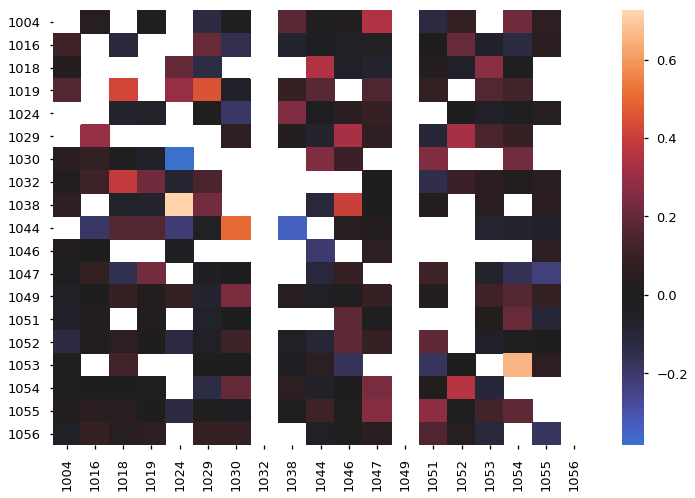

In [410]:
plt.figure(figsize=(12,8))
sns.heatmap(AUCheatmap,center=0)

In [246]:
diffs2.index=diffs2.trainsub

In [247]:
diffs2.head()

,3,trainsub,testsub
trainsub,,,
1053,0.034821,1053,1054
1054,-0.240833,1054,1024
1018,0.449259,1018,1044
1053,NaN,1053,1056
1047,NaN,1047,1056


In [189]:
results['test'] = testsublist

In [190]:
diffs['trainsub']=trainsublist

In [191]:
diffs.head()

,3,4,trainsub
0,0.192661,0.204375,"[1051, 1054, 1029, 1047]"
1,0.011701,-0.111161,"[1046, 1044, 1056, 1049]"
2,-0.064536,-0.202340,"[1047, 1038, 1044, 1004]"
3,-0.223402,0.034203,"[1030, 1049, 1004, 1047]"
4,-0.272222,-0.414722,"[1046, 1054, 1029, 1044]"


In [412]:
diffs1 = diffs[3]

In [413]:
diffs=diffs[~diffs[3].isnull()]

In [414]:
pos_sub=diffs[diffs[4]>0].trainsub.values

In [415]:
neg_sub=diffs[diffs[4]<=0].trainsub.values

In [416]:
neg_sub.reshape(35,1)[1]

ValueError: cannot reshape array of size 170 into shape (35,1)

In [133]:
pos_sub.reshape(1,-1).reshape(58,1)[1]

array([array([1024, 1052, 1038, 1051])], dtype=object)

In [137]:
pos_sub2 = np.empty((58,4))
c=0
for i in pos_sub:
    pos_sub2[c]=i
    c+=1

In [152]:
neg_sub2 = np.empty((35,4))
c=0
for i in neg_sub:
    neg_sub2[c]=i
    c+=1

In [146]:
pos_sub2=pos_sub2.reshape(1,58*4)

In [153]:
neg_sub2=neg_sub2.reshape(1,35*4)

In [163]:
len(np.unique(pos_sub2))

19

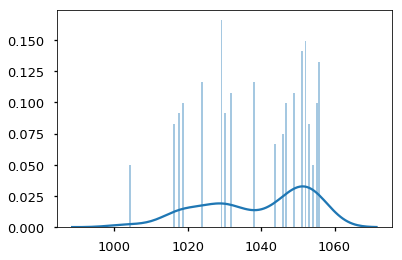

In [166]:
sns.distplot(pos_sub2.T,bins=100)

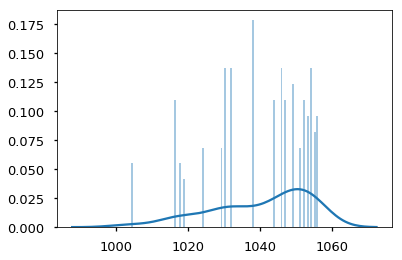

In [167]:
sns.distplot(neg_sub2.T,bins=100)

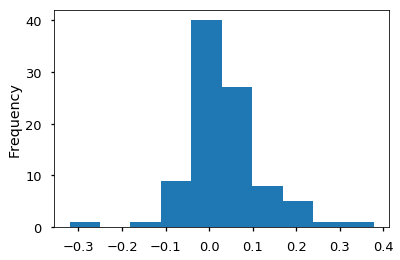

In [88]:
diffs[4].plot(kind='hist')

Bradykinesia Results

In [17]:
results=pd.read_csv('SimsMultiSubj234_Brady.csv',index_col=False)
results=results.drop('Unnamed: 0',axis=1)

In [48]:
results2=results.iloc[:,1:].copy()

In [49]:
baseline = results.iloc[:,0].copy()

In [50]:
diffs = results2.apply(lambda x:x - baseline)

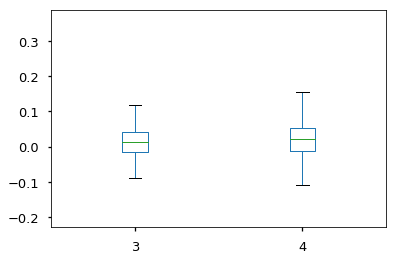

In [51]:
diffs.plot(kind='box')

ValueError: cannot convert float NaN to integer

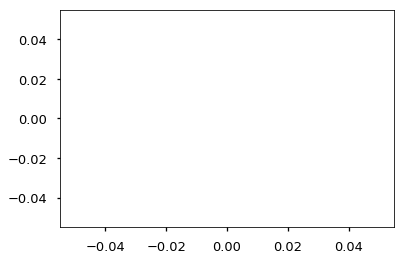

In [52]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [23]:
diffs['TestSubj']= testsublist

In [28]:
diffs.head(5)

,3,4,TestSubj
0,0.040468,-0.025557,1051
1,0.017266,-0.001753,1029
2,-0.079182,-0.057752,1038
3,0.002968,0.022137,1056
4,-0.024277,-0.003179,1029


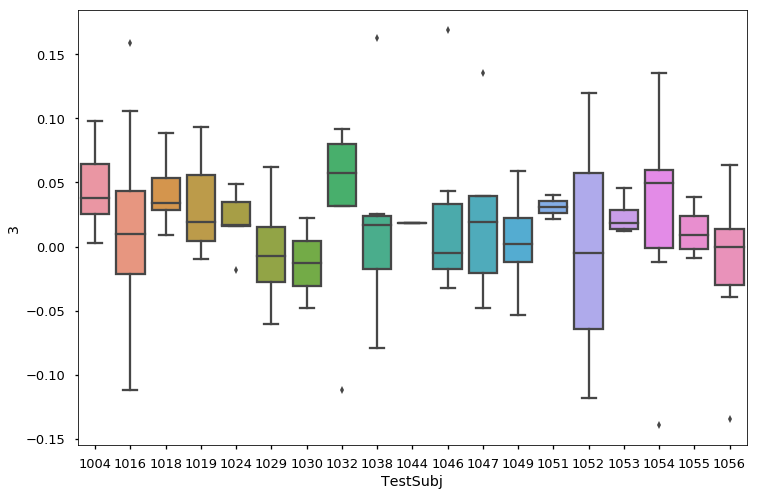

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='TestSubj',y='3',data=diffs)

In [3]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='16',data=diffs)

### Tremor Results

In [237]:
results=pd.read_csv('SimsMultiSubj_Tremor.csv',index_col=False)

In [238]:
results=results.drop('Unnamed: 0',axis=1)

In [239]:
results=results.dropna()

In [240]:
results2=results.iloc[:,1:].copy()

In [241]:
baseline = results.iloc[:,0].copy()

In [242]:
diffs = results2.apply(lambda x:x - baseline)

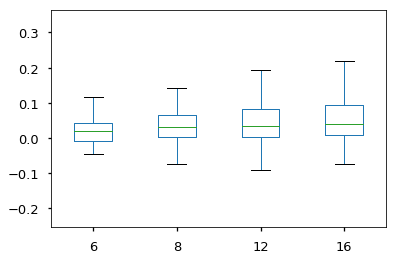

In [243]:
diffs.plot(kind='box')

-0.116055849322 0.177949411558
-0.0691723836327 0.186991451785
-0.0855872511339 0.181640949656
-0.0657825338663 0.214298338209


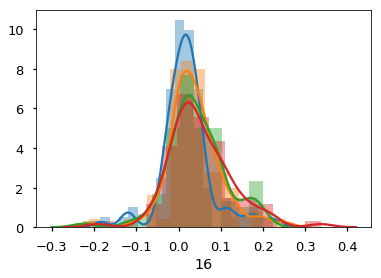

In [248]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [255]:
Xtr.shape

(25552, 56)

In [1]:
# y=np.asarray(diffs)
# x = diffs.columns.values
# sns.tsplot(y,x,ci='sd')

### Global models - on Day 1 and Day 2

In [12]:
Dataorig = Data.copy()

In [43]:
Data[symptom].unique()

array([  0.,   1.,  nan,   2.,   3.,   4.])

### Train on 1 session

In [102]:
# t1=time.time()
# res_all = pd.DataFrame()
# auroc1 = []
# auroc2 = []

# for symptom in ['Tremor']:
    
#     Data = Dataorig.copy() #original unmodified dataframe
#     #remove nan rows for current symptom
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index

#     for s in Dataorig.Subject.unique():
        
#         #train on 1 session - CV on all 5 sessions
#         dtrain = Data[(Data.Subject != s) & (Data.Visit == '2 Weeks: Time 0') ].copy()
#         dtest = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
#         dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()
    
#         X = dtrain.iloc[:,7:].as_matrix()
#         fnames = dtrain.iloc[:,7:].columns.values
#         indp = ((dtrain[symptom]>0))
#         indp = indp.values
#         y = indp.astype(int) #target 
#         print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

#         clf = RandomForestClassifier(n_estimators=50,random_state=2)
#         clf.fit(X,y)
#         #test on day 1 for left out subjects
#         Xte = dtest.iloc[:,7:].as_matrix()
#         yte = (dtest[symptom]>0).values.astype(int) 
#         yscore = clf.predict_proba(Xte)
#         yscore = yscore[:,1]
#         if len(np.unique(yte))>1:
#             auroc = roc_auc_score(yte,yscore)
#         else:
#             print('only 1 class in test data - cannot compute roc curve')
#             auroc = np.nan
#         auroc1.append(auroc) #auc from each subject when tested on day 2

#         #test on day 2
#         if dtest2.empty is False:
#             Xte = dtest2.iloc[:,7:].as_matrix()
#             yte = (dtest2[symptom]>0).values.astype(int) 
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]
#             if len(np.unique(yte))>1:
#                 auroc = roc_auc_score(yte,yscore)
#             else:
#                 print('only 1 class in test data - cannot compute roc curve')
#                 auroc = np.nan
#             auroc2.append(auroc) #auc from each subject when tested on day 2
#         else:
#             auroc2.append(np.nan)
#         print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f, day1data/day2data'%(s,auroc1[-1],auroc2[-1]))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [103]:
# ax=plt.boxplot([auroc1,np.asarray(auroc2)[~np.isnan(auroc2)]])

Tremor

In [104]:
# ax=plt.boxplot([np.asarray(auroc1)[~np.isnan(auroc1)],np.asarray(auroc2)[~np.isnan(auroc2)]])

Compute AUC on each test visit

In [105]:
# t1=time.time()
# res_all = pd.DataFrame()
# auroc1 = []; 
# auroc2 = []

# for symptom in ['Bradykinesia']:
    
#     Data = Dataorig.copy() #original unmodified dataframe
#     #remove nan rows for current symptom
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index

#     for s in Dataorig.Subject.unique():
        
#         auroc1_v=[]
        
#         #train on 1 session - CV on all 5 sessions
#         dtrain = Data[(Data.Subject != s) & (Data.Visit == '2 Weeks: Time 0') ].copy()
#         dtest1 = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
#         dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()
    
#         X = dtrain.iloc[:,7:].as_matrix()
#         fnames = dtrain.iloc[:,7:].columns.values
#         indp = ((dtrain[symptom]>0))
#         indp = indp.values
#         y = indp.astype(int) #target 
#         print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
        
#         for v in dtest1.Visit.unique():
#             dtest = dtest1[dtest1.Visit == v].copy()

#             clf = RandomForestClassifier(n_estimators=50,random_state=2)
#             clf.fit(X,y)
#             #test on day 1 for left out subjects
#             Xte = dtest.iloc[:,7:].as_matrix()
#             yte = (dtest[symptom]>0).values.astype(int) 
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]
#             if len(np.unique(yte))>1:
#                 auroc = roc_auc_score(yte,yscore)
#             else:
#                 print('only 1 class in test data - cannot compute roc curve')
#                 auroc = np.nan
#             auroc1_v.append(auroc) #auc from each subject when tested on day 2
#         print(auroc1_v)
#         auroc1.append(np.nanmean(auroc1_v))

#             #test on day 2
#         if dtest2.empty is False:
#             Xte = dtest2.iloc[:,7:].as_matrix()
#             yte = (dtest2[symptom]>0).values.astype(int) 
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]
#             if len(np.unique(yte))>1:
#                 auroc = roc_auc_score(yte,yscore)
#             else:
#                 print('only 1 class in test data - cannot compute roc curve')
#                 auroc = np.nan
#             auroc2.append(auroc) #auc from each subject when tested on day 2
#         else:
#             auroc2.append(np.nan)
#         print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f'%(s,auroc1[-1],auroc2[-1]))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

There is a lot of variance on day 1 test sessions

#### Cross validate on visits 

In [81]:
t1=time.time()
res_all = pd.DataFrame()
auroc1_1 = []
auroc2_1 = []

for symptom in ['Bradykinesia']:
    
    Data = Dataorig.copy() #original unmodified dataframe
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index

    for s in Dataorig.Subject.unique():
        auroc1_v = []; auroc2_v=[]

        #train on 1 session day 1 - CV on all 5 sessions
        dtrain1 = Data[(Data.Subject != s) & (Data.Visit != '4 Weeks')].copy()
        dtest = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
        dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()
        
        for v in dtrain1.Visit.unique():
            dtrain=dtrain1[dtrain1.Visit == v]
    
            X = dtrain.iloc[:,7:].as_matrix()
            fnames = dtrain.iloc[:,7:].columns.values
            indp = ((dtrain[symptom]>0))
            indp = indp.values
            y = indp.astype(int) #target 
            if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in data - skipping')
                continue

            
#             print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

            clf = RandomForestClassifier(n_estimators=50,random_state=2)
            clf.fit(X,y)
            #test on day 1 for left out subjects
            Xte = dtest.iloc[:,7:].as_matrix()
            yte = (dtest[symptom]>0).values.astype(int) 
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            auroc1_v.append(auroc) #auc for training on current visit 
            
            #test on day 2
            if dtest2.empty is False:
                Xte = dtest2.iloc[:,7:].as_matrix()
                yte = (dtest2[symptom]>0).values.astype(int) 
                yscore = clf.predict_proba(Xte)
                yscore = yscore[:,1]
                if len(np.unique(yte))>1:
                    auroc = roc_auc_score(yte,yscore)
                else:
                    print('only 1 class in test data - cannot compute roc curve')
                    auroc = np.nan
                auroc2_v.append(auroc) #auc from each subject when tested on day 2
            else:
                auroc2_v.append(np.nan)
            print(auroc1_v[-1],auroc2_v[-1])

        auroc1_1.append(np.nanmean(auroc1_v))
        auroc2_1.append(np.nanmean(auroc2_v))

        print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f'%(s,auroc1_1[-1],auroc2_1[-1]))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

0.7490844676574306 0.7036477036477036
0.718331941022167 0.7373842373842374
0.6655212274802444 0.6366943866943867
0.7233232010520725 0.6802116802116802
0.7276721259304499 0.6894254394254394
0.7012147037419241 0.6120298620298621
Subject 1004, AUC day1 = 0.71, AUC day2 = 0.68
0.7752242926155969 0.9981464318813716
0.8113586064110802 1.0
0.7245424906594322 0.9959839357429718
0.8341852883082268 0.9933580475749151
0.7450155874443731 0.9856348470806303
0.7073986816115752 0.9919678714859438
Subject 1016, AUC day1 = 0.77, AUC day2 = 0.99
0.7695014662756599 0.693268921095008
0.7832969979935175 0.7142351046698874
0.7767219092452539 0.7009017713365538
0.7911396434634973 0.6962640901771335
0.7621295724648866 0.6818357487922705
0.7773190307146164 0.7201288244766505
Subject 1018, AUC day1 = 0.78, AUC day2 = 0.70
0.8136788312014046 0.8579831932773109
0.8083061616921662 0.9119397759103642
0.8466254911796672 0.8911414565826331
0.8178016052169551 0.885749299719888
0.8197631886965974 0.8622549019607844
0.8

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


0.45615494363584075 0.6484154143728612
0.4605077285723147 0.5688885582502604
0.5568766248047415 0.6488121807270744
0.5097495333532587 0.5989932053761842
0.49667567064608725 0.5538114367901603
0.5060107201867715 0.6039279869067102
Subject 1049, AUC day1 = 0.50, AUC day2 = 0.60
0.7296673896039252 0.532781954887218
0.7259297447201878 0.5599498746867168
0.7353849640901657 0.5346365914786968
0.709408109933869 0.5621052631578947
0.6847512088459077 0.5241604010025063
0.6792780701130626 0.5456641604010025
Subject 1051, AUC day1 = 0.71, AUC day2 = 0.54
0.7247331914064674 nan
0.7247358003562085 nan
0.763438700116881 nan
0.7670729671063616 nan
0.7236670006122333 nan
0.8010545374853899 nan
Subject 1052, AUC day1 = 0.75, AUC day2 = nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


0.7877181032224261 nan
0.7458737228189677 nan
0.757100689896079 nan
0.7610077722469654 nan
0.7455174220592088 nan
0.689272552615492 nan
Subject 1053, AUC day1 = 0.75, AUC day2 = nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


0.7751206579258293 nan
0.7801429993340542 nan
0.7514742107109867 nan
0.7813594245655239 nan
0.7985880874465632 nan
0.767116776822221 nan
Subject 1054, AUC day1 = 0.78, AUC day2 = nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


0.6724793158976068 nan
0.6606285746015881 nan
0.6193425509467488 nan
0.6478638458548504 nan
0.603237270253762 nan
0.6670064967516243 nan
Subject 1055, AUC day1 = 0.65, AUC day2 = nan


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


0.6448193872176957 nan
0.5590108894327581 nan
0.5515040738560675 nan
0.5341243532947118 nan
0.5602171690572819 nan
0.5115845441308591 nan
Subject 1056, AUC day1 = 0.56, AUC day2 = nan
Elapsed time = 1.810 min


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


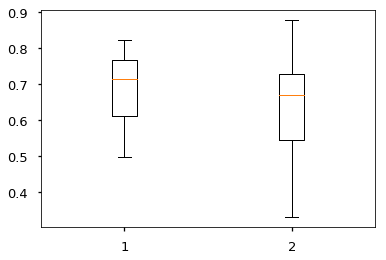

In [51]:
ax=plt.boxplot([auroc1_1,np.asarray(auroc2_1)[~np.isnan(auroc2_1)]])

Tremor

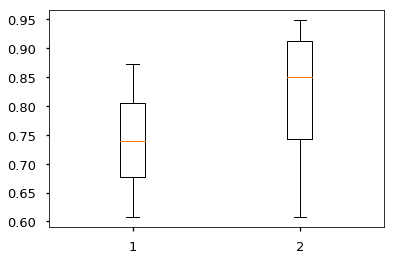

In [60]:
ax=plt.boxplot([np.asarray(auroc1_1)[~np.isnan(auroc1_1)],np.asarray(auroc2_1)[~np.isnan(auroc2_1)]])

## Train on all sessions Day 1

In [82]:
t1=time.time()
res_all = pd.DataFrame()
auroc1_6 = []
auroc2_6 = []

for symptom in ['Bradykinesia']:
    
    Data = Dataorig.copy() #original unmodified dataframe
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index

    for s in Dataorig.Subject.unique():
        
        #train on 6 sessions (all day 1)
        dtrain = Data[(Data.Subject != s) & (Data.Visit != '4 Weeks') ].copy()
        dtest = Data[(Data.Subject == s) & (Data.Visit != '4 Weeks')].copy()
        dtest2 = Data[(Data.Subject == s) & (Data.Visit == '4 Weeks')].copy()
    
        X = dtrain.iloc[:,7:].as_matrix()
        fnames = dtrain.iloc[:,7:].columns.values
        indp = ((dtrain[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

        clf = RandomForestClassifier(n_estimators=50,random_state=2)
        clf.fit(X,y)
        #test on day 1 for left out subjects
        Xte = dtest.iloc[:,7:].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc1_6.append(auroc) #auc from each subject when tested on day 2

        #test on day 2
        if dtest2.empty is False:
            Xte = dtest2.iloc[:,7:].as_matrix()
            yte = (dtest2[symptom]>0).values.astype(int) 
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            auroc2_6.append(auroc) #auc from each subject when tested on day 2
        else:
            auroc2_6.append(np.nan)
        print('Subject %d, AUC day1 = %.2f, AUC day2 = %.2f'%(s,auroc1_6[-1],auroc2_6[-1]))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 14273/27526 = 0.52
Subject 1004, AUC day1 = 0.74, AUC day2 = 0.65
Rows w Bradykinesia 13285/27320 = 0.49
Subject 1016, AUC day1 = 0.71, AUC day2 = 1.00
Rows w Bradykinesia 13898/27458 = 0.51
Subject 1018, AUC day1 = 0.80, AUC day2 = 0.72
Rows w Bradykinesia 14291/27391 = 0.52
Subject 1019, AUC day1 = 0.85, AUC day2 = 0.91
Rows w Bradykinesia 13714/27368 = 0.50
Subject 1024, AUC day1 = 0.74, AUC day2 = 0.75
Rows w Bradykinesia 13834/27244 = 0.51
Subject 1029, AUC day1 = 0.50, AUC day2 = 0.38
Rows w Bradykinesia 14027/27480 = 0.51
Subject 1030, AUC day1 = 0.79, AUC day2 = 0.76
Rows w Bradykinesia 12959/26866 = 0.48
Subject 1032, AUC day1 = 0.50, AUC day2 = 0.70
Rows w Bradykinesia 14300/27258 = 0.52
Subject 1038, AUC day1 = 0.54, AUC day2 = 0.28
Rows w Bradykinesia 13954/27350 = 0.51
Subject 1044, AUC day1 = 0.76, AUC day2 = 0.81
Rows w Bradykinesia 14172/27556 = 0.51
Subject 1046, AUC day1 = 0.73, AUC day2 = 0.53
Rows w Bradykinesia 14593/27650 = 0.53
Subject 1047, A

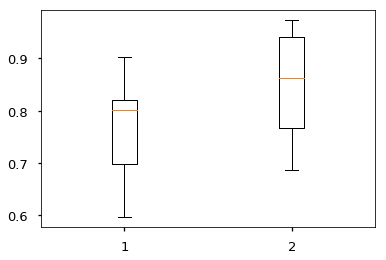

In [50]:
ax=plt.boxplot([auroc1_6,np.asarray(auroc2_6)[~np.isnan(auroc2_6)]])

Tremor

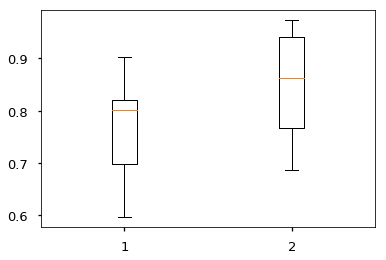

In [59]:
ax=plt.boxplot([np.asarray(auroc1_6)[~np.isnan(auroc1_6)],np.asarray(auroc2_6)[~np.isnan(auroc2_6)]])

In [83]:
Day1NanInds = np.isnan(auroc1_1)|np.isnan(auroc1_6)
Day2NanInds = np.isnan(auroc2_1)|np.isnan(auroc2_6)
auroc1_1 = np.asarray(auroc1_1)[~Day1NanInds]
auroc1_6 = np.asarray(auroc1_6)[~Day1NanInds]
auroc2_1 = np.asarray(auroc2_1)[~Day2NanInds]
auroc2_6 = np.asarray(auroc2_6)[~Day2NanInds]

Bradykinesia Day 1 p-value: 0.013612
Bradykinesia Day 2 p-value: 0.394027


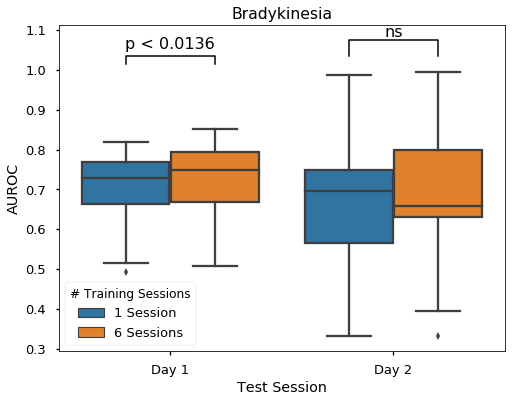

In [72]:
g1 = np.shape(auroc1_1)[0]*['Day 1']
g2 = np.shape(auroc2_1)[0]*['Day 2']
df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(auroc1_1) + list(auroc2_1)),
                             '6 Sessions':(list(auroc1_6) + list(auroc2_6))})
df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','6 Sessions'],var_name=['# Training Sessions'])

plt.figure(figsize=(8,6))
ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Bradykinesia')

#stats
# _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
_, pvalue1 = stats.ttest_rel(auroc1_1,auroc1_6)
print('Bradykinesia Day 1 p-value: %f'%pvalue1)

# _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
_, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_6)
print('Bradykinesia Day 2 p-value: %f'%pvalue2)

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

if pvalue1 > 0.05:
    plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
else:
    plt.text((x1+x2)*.5, y+h+0.01, "p < %.4f"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

if pvalue2 > 0.05:
    plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
else:
    plt.text((x3+x4)*.5, y+h, "p < %.4f"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.svg'))
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'))

Bradykinesia Day 1 p-value: 0.000175
Bradykinesia Day 2 p-value: 0.000385


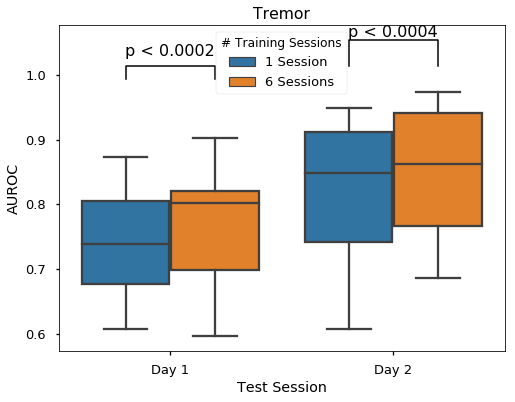

In [58]:
g1 = np.shape(auroc1_1)[0]*['Day 1']
g2 = np.shape(auroc2_1)[0]*['Day 2']
df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(auroc1_1) + list(auroc2_1)),
                             '6 Sessions':(list(auroc1_6) + list(auroc2_6))})
df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','6 Sessions'],var_name=['# Training Sessions'])

plt.figure(figsize=(8,6))
ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Tremor')

#stats
# _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
_, pvalue1 = stats.ttest_rel(auroc1_1,auroc1_6)
print('Bradykinesia Day 1 p-value: %f'%pvalue1)

# _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
_, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_6)
print('Bradykinesia Day 2 p-value: %f'%pvalue2)

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

if pvalue1 > 0.05:
    plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
else:
    plt.text((x1+x2)*.5, y+h+0.01, "p < %.4f"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

if pvalue2 > 0.05:
    plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
else:
    plt.text((x3+x4)*.5, y+h, "p < %.4f"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.svg'))
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'))

In [101]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [65]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc,rangeYacc,rangeZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.750286,0.950312,0.792986,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.593042,0.814818,0.511329,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


Train on 1 session

Subject 1004
Training Random Forest
rows with symptom = 158/312

Subj/Visit 0, prec=0.013, rec=1.000, Spec=0.269, auroc_train=1.000, auroc=0.818
rows with symptom = 0/260
only 1 class available in train data - skipping
rows with symptom = 0/270
only 1 class available in train data - skipping
rows with symptom = 13/279

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.512
rows with symptom = 0/261
only 1 class available in train data - skipping
rows with symptom = 0/263
only 1 class available in train data - skipping
f1_test=0.044+/-0.018, prec=0.507+/-0.493, rec=0.516+/-0.484, auprc=0.155+/-0.094, auroc=0.665+/-0.153
Test 1004 on day 2
Subject 1016
Training Random Forest
rows with symptom = 148/309

Subj/Visit 0, prec=0.775, rec=0.853, Spec=0.706, auroc_train=1.000, auroc=0.869
rows with symptom = 172/317

Subj/Visit 1, prec=0.850, rec=0.907, Spec=0.820, auroc_train=1.000, auroc=0.927
rows with symptom = 163/304

Subj/Visit 2, prec=0.828, rec=0.875, Spec=0.79

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.510
f1_test=0.146+/-0.154, prec=0.433+/-0.325, rec=0.301+/-0.398, auprc=0.372+/-0.058, auroc=0.594+/-0.065
Test 1024 on day 2
Subject 1029
Training Random Forest
rows with symptom = 257/334

Subj/Visit 0, prec=0.339, rec=0.965, Spec=0.268, auroc_train=1.000, auroc=0.714
rows with symptom = 44/309

Subj/Visit 1, prec=0.867, rec=0.019, Spec=0.998, auroc_train=1.000, auroc=0.710
rows with symptom = 47/351

Subj/Visit 2, prec=0.850, rec=0.026, Spec=0.997, auroc_train=1.000, auroc=0.628
rows with symptom = 176/323

Subj/Visit 3, prec=0.471, rec=0.845, Spec=0.538, auroc_train=1.000, auroc=0.738
rows with symptom = 110/322

Subj/Visit 4, prec=0.589, rec=0.535, Spec=0.783, auroc_train=1.000, auroc=0.716
rows with symptom = 78/320

Subj/Visit 5, prec=0.664, rec=0.271, Spec=0.913, auroc_train=1.000, auroc=0.733
f1_test=0.357+/-0.231, prec=0.630+/-0.190, rec=0.444+/-0.371, auprc=0.557+/-0.043, auroc=0.706+/-0.036
Test 10

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:101: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:102: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:103: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:110: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.056, rec=0.667, Spec=0.761, auroc_train=1.000, auroc=0.772
rows with symptom = 0/306
only 1 class available in train data - skipping
rows with symptom = 0/257
only 1 class available in train data - skipping
rows with symptom = 30/294

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.658
rows with symptom = 0/288
only 1 class available in train data - skipping
rows with symptom = 0/297
only 1 class available in train data - skipping
f1_test=0.082+/-0.021, prec=0.528+/-0.472, rec=0.349+/-0.317, auprc=0.157+/-0.001, auroc=0.715+/-0.057
Subject 1053
Training Random Forest
rows with symptom = 0/279
only 1 class available in train data - skipping
rows with symptom = 0/256
only 1 class available in train data - skipping
rows with symptom = 0/246
only 1 class available in train data - skipping
rows with symptom = 0/284
only 1 class available in train data - skipping
rows with symptom = 0/258
only 1 class available in train data - skipping
rows w

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:101: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:102: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:103: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:110: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.p


Subj/Visit 0, prec=0.787, rec=0.995, Spec=0.007, auroc_train=1.000, auroc=0.574
rows with symptom = 163/271

Subj/Visit 1, prec=0.853, rec=0.649, Spec=0.333, auroc_train=1.000, auroc=0.559
rows with symptom = 177/271

Subj/Visit 2, prec=0.872, rec=0.821, Spec=0.335, auroc_train=1.000, auroc=0.647
rows with symptom = 239/266

Subj/Visit 3, prec=0.821, rec=0.956, Spec=0.185, auroc_train=1.000, auroc=0.600
rows with symptom = 216/270

Subj/Visit 4, prec=0.848, rec=0.824, Spec=0.346, auroc_train=1.000, auroc=0.637
rows with symptom = 254/256

Subj/Visit 5, prec=0.779, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.506
f1_test=0.843+/-0.050, prec=0.827+/-0.034, rec=0.874+/-0.125, auprc=0.885+/-0.012, auroc=0.587+/-0.048
Subject 1056
Training Random Forest
rows with symptom = 306/333

Subj/Visit 0, prec=0.720, rec=0.956, Spec=0.068, auroc_train=1.000, auroc=0.519
rows with symptom = 116/310

Subj/Visit 1, prec=0.889, rec=0.386, Spec=0.781, auroc_train=1.000, auroc=0.620
rows with symptom

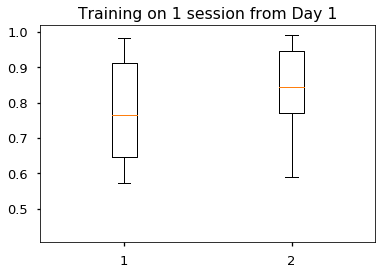

In [90]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 
    
    if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
        print('only 1 class available in data - skipping')
        continue

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2

auroc2_1 = np.asarray(auroc2_1)
ax=plt.boxplot([day1_1.values[~np.isnan(day1_1.values)], auroc2_1[~np.isnan(auroc2_1)]])
plt.title('Training on 1 session from Day 1')

    


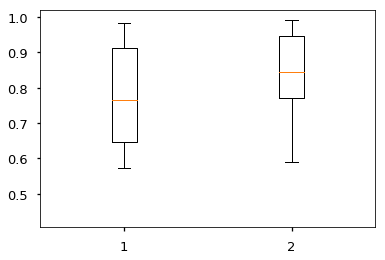

In [89]:
auroc2_1 = np.asarray(auroc2_1)
ax=plt.boxplot([day1_1.values[~np.isnan(day1_1.values)], auroc2_1[~np.isnan(auroc2_1)]])


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.200, rec=0.972, Spec=0.052, auroc_train=1.000, auroc=0.435

Subj/Visit 1, prec=0.333, rec=0.045, Spec=0.949, auroc_train=1.000, auroc=0.604

Subj/Visit 2, prec=0.647, rec=0.050, Spec=0.983, auroc_train=1.000, auroc=0.704

Subj/Visit 3, prec=0.428, rec=0.278, Spec=0.823, auroc_train=1.000, auroc=0.690

Subj/Visit 4, prec=0.828, rec=0.055, Spec=0.993, auroc_train=1.000, auroc=0.621

Subj/Visit 5, prec=0.526, rec=0.198, Spec=0.901, auroc_train=1.000, auroc=0.695
f1_test=0.205+/-0.115, prec=0.494+/-0.205, rec=0.266+/-0.328, auprc=0.460+/-0.102, auroc=0.625+/-0.093
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.940, rec=0.997, Spec=0.412, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.970, rec=0.958, Spec=0.687, auroc_train=1.000, auroc=0.879

Subj/Visit 2, prec=0.973, rec=0.956, Spec=0.718, auroc_train=1.000, auroc=0.904

Subj/Visit 3, prec=0.938, rec=0.990, Spec=0.409, auroc_train=1.000, auroc=0.

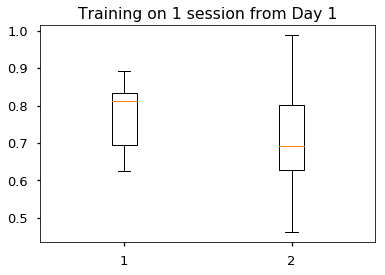

In [64]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2

ax=plt.boxplot([day1_1.values, auroc2_1])
plt.title('Training on 1 session from Day 1')

    


Train on 5 sessions

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.696, rec=0.132, Spec=0.548, auroc_train=1.000, auroc=0.454

Subj/Visit 1, prec=0.294, rec=0.286, Spec=0.870, auroc_train=1.000, auroc=0.673

Subj/Visit 2, prec=0.625, rec=0.625, Spec=0.955, auroc_train=1.000, auroc=0.919

Subj/Visit 3, prec=0.578, rec=0.678, Spec=0.699, auroc_train=1.000, auroc=0.743

Subj/Visit 4, prec=0.379, rec=0.846, Spec=0.812, auroc_train=1.000, auroc=0.913

Subj/Visit 5, prec=0.724, rec=0.457, Spec=0.955, auroc_train=1.000, auroc=0.894
f1_test=0.474+/-0.160, prec=0.549+/-0.159, rec=0.504+/-0.242, auprc=0.596+/-0.179, auroc=0.766+/-0.167
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.988, rec=0.972, Spec=0.786, auroc_train=1.000, auroc=0.975

Subj/Visit 1, prec=0.971, rec=0.996, Spec=0.767, auroc_train=1.000, auroc=0.989

Subj/Visit 2, prec=0.953, rec=1.000, Spec=0.607, auroc_train=1.000, auroc=0.996

Subj/Visit 3, prec=1.000, rec=0.954, Spec=1.000, auroc_train=1.000, auroc=0.

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.796, rec=0.738, Spec=0.775, auroc_train=1.000, auroc=0.841

Subj/Visit 1, prec=0.849, rec=0.837, Spec=0.821, auroc_train=1.000, auroc=0.888

Subj/Visit 2, prec=0.791, rec=0.861, Spec=0.723, auroc_train=1.000, auroc=0.898

Subj/Visit 3, prec=0.890, rec=0.720, Spec=0.888, auroc_train=1.000, auroc=0.878

Subj/Visit 4, prec=0.840, rec=0.862, Spec=0.807, auroc_train=1.000, auroc=0.916

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.814
f1_test=0.807+/-0.035, prec=0.824+/-0.039, rec=0.794+/-0.060, auprc=0.894+/-0.033, auroc=0.872+/-0.035
Test 1049 on day 2
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.091, Spec=1.000, auroc_train=1.000, auroc=0.771

Sub

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.962+/-0.032, prec=0.934+/-0.058, rec=0.993+/-0.009, auprc=0.989+/-0.013, auroc=0.935+/-0.042


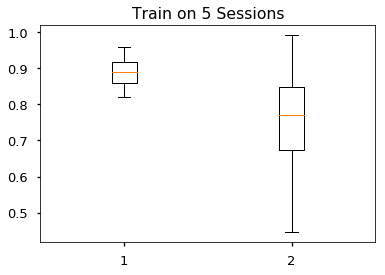

In [58]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

    
ax=plt.boxplot([day1_5.values, auroc2_5])
plt.title('Train on 5 Sessions from Day 1')

# Subgroup of tasks - Train and Test on subgroups of tasks (Just for reference, NOT USED in current version of the paper)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Tremor 1333/3187 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.757, rec=0.812, Spec=0.926, auroc_train=1.000, auroc=0.923

Subj/Visit 1, prec=0.768, rec=0.495, Spec=0.698, auroc_train=1.000, auroc=0.648

Subj/Visit 2, prec=0.802, rec=0.901, Spec=0.778, auroc_train=1.000, auroc=0.930

Subj/Visit 3, prec=0.562, rec=0.800, Spec=0.776, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.775, rec=0.392, Spec=0.892, auroc_train=1.000, auroc=0.683

Subj/Visit 5, prec=0.717, rec=0.804, Spec=0.460, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=0.949, rec=0.825, Spec=0.922, auroc_train=1.000, auroc=0.939

Subj/Visit 7, prec=0.521, rec=0.700, Spec=0.408, auroc_train=1.000, auroc=0.566

Subj/Visit 8, prec=0.894, rec=0.596, Spec=0.389, auroc_train=1.000, auroc=0.405

Subj/Visit 9, prec=0.758, rec=0.625, Spec=0.830, auroc_train=1.000, auroc=0.838

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.0

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.286, rec=0.833, Spec=0.781, auroc_train=1.000, auroc=0.875

Subj/Visit 17, prec=1.000, rec=0.328, Spec=1.000, auroc_train=1.000, auroc=0.751

Subj/Visit 18, prec=0.979, rec=0.354, Spec=0.958, auroc_train=1.000, auroc=0.747
f1_test=0.504+/-0.281, prec=0.570+/-0.336, rec=0.512+/-0.297, auprc=0.631+/-0.302, auroc=0.750+/-0.150

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Tremor 895/6673 = 0.13
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.124


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.322, Spec=1.000, auroc_train=1.000, auroc=0.945


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.631, rec=0.745, Spec=0.932, auroc_train=1.000, auroc=0.950


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.804

Subj/Visit 18, prec=0.992, rec=0.510, Spec=0.987, auroc_train=1.000, auroc=0.799
f1_test=0.099+/-0.226, prec=0.191+/-0.376, rec=0.084+/-0.203, auprc=0.678+/-0.362, auroc=0.709+/-0.282

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Tremor 3714/12167 = 0.31
Training Random Forest

Subj/Visit 0, prec=0.421, rec=0.232, Spec=0.935, auroc_train=1.000, auroc=0.707

Subj/Visit 1, prec=0.894, rec=0.063, Spec=0.952, auroc_train=1.000, auroc=0.531

Subj/Visit 2, prec=0.167, rec=0.087, Spec=0.938, auroc_train=1.000, auroc=0.555

Subj/Visit 3, prec=0.028, rec=0.042, Spec=0.948, auroc_train=1.000, auroc=0.509

Subj/Visit 4, prec=0.569, rec=0.120, Spec=0.947, auroc_train=1.000, auroc=0.587

Subj/Visit 5, prec=0.744, rec=0.450, Spec=0.780

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=1.000, rec=0.237, Spec=1.000, auroc_train=1.000, auroc=0.731


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.930, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.504


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.691, rec=0.506, Spec=0.748, auroc_train=1.000, auroc=0.672


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.913, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.365, rec=0.342, Spec=0.909, auroc_train=1.000, auroc=0.728


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.957, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.176, Spec=0.821, auroc_train=1.000, auroc=0.430

Subj/Visit 18, prec=0.879, rec=0.269, Spec=0.867, auroc_train=1.000, auroc=0.624
f1_test=0.176+/-0.199, prec=0.348+/-0.376, rec=0.133+/-0.159, auprc=0.481+/-0.343, auroc=0.569+/-0.151

 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Tremor 2227/10303 = 0.22
Training Random Forest

Subj/Visit 0, prec=0.241, rec=0.140, Spec=0.955, auroc_train=1.000, auroc=0.782

Subj/Visit 1, prec=0.905, rec=0.083, Spec=0.994, auroc_train=1.000, auroc=0.805

Subj/Visit 2, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.823


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.364, rec=0.019, Spec=0.982, auroc_train=1.000, auroc=0.667

Subj/Visit 5, prec=0.658, rec=0.200, Spec=0.922, auroc_train=1.000, auroc=0.676


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.807

Subj/Visit 8, prec=0.963, rec=0.270, Spec=0.980, auroc_train=1.000, auroc=0.845


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=0.418


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.699, rec=0.657, Spec=0.768, auroc_train=1.000, auroc=0.777


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.133, rec=0.051, Spec=0.967, auroc_train=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.968, rec=0.276, Spec=0.975, auroc_train=1.000, auroc=0.789

Subj/Visit 18, prec=0.915, rec=0.328, Spec=0.942, auroc_train=1.000, auroc=0.780
f1_test=0.153+/-0.204, prec=0.360+/-0.409, rec=0.111+/-0.167, auprc=0.501+/-0.320, auroc=0.730+/-0.119


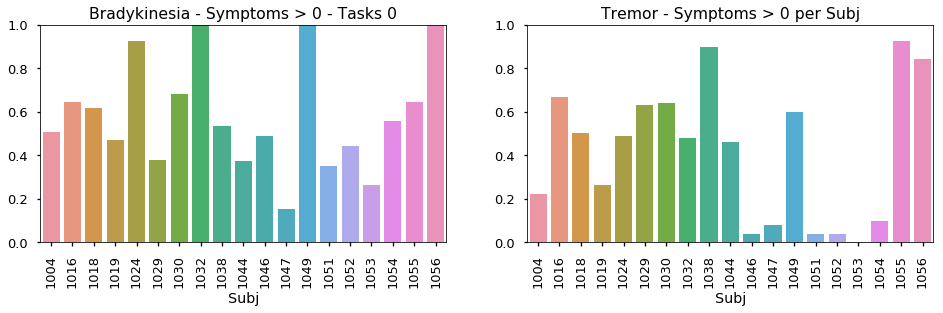

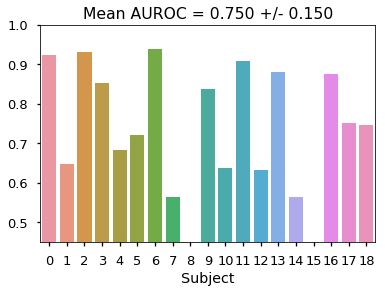

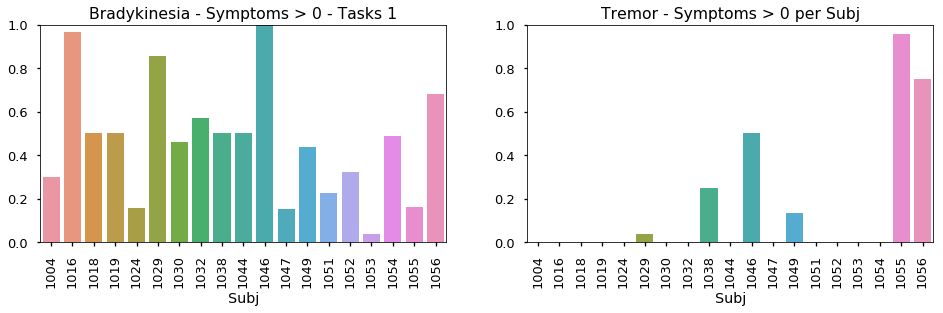

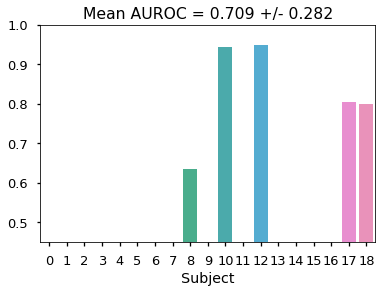

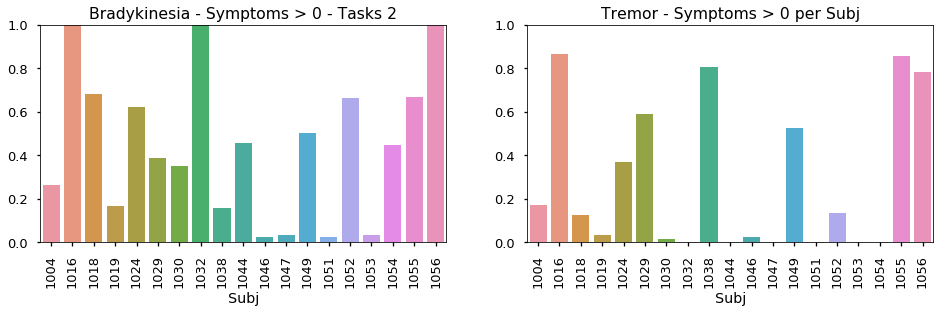

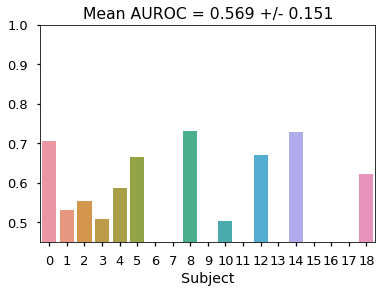

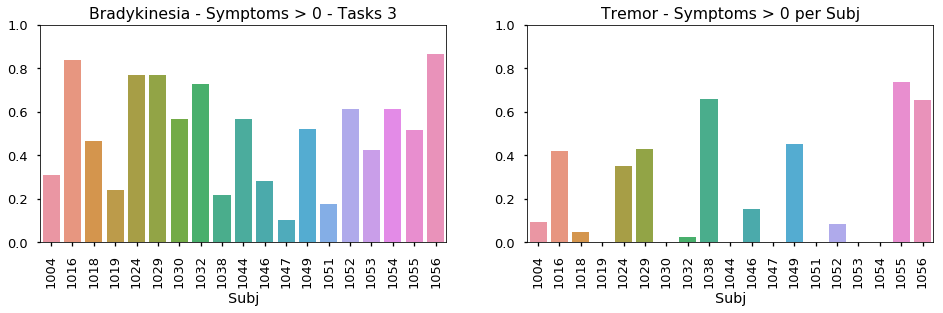

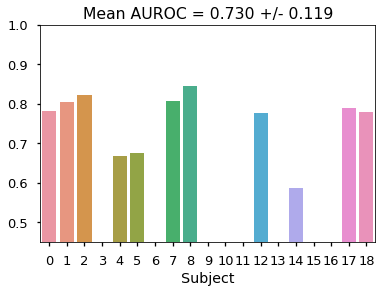

In [146]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


In [155]:
results_task

,Structured,Walking,Gross,Fine
0,0.922903,NaN,0.707092,0.781829
1,0.647593,NaN,0.531026,0.804820
2,0.929889,NaN,0.555182,0.822650
3,0.852089,NaN,0.509034,NaN
4,0.682934,NaN,0.587154,0.667278
5,0.722296,0.123789,0.664273,0.676325
6,0.939076,NaN,0.152212,NaN
7,0.565590,NaN,NaN,0.807216
8,0.404558,0.636013,0.730609,0.844780
9,0.838497,NaN,NaN,NaN


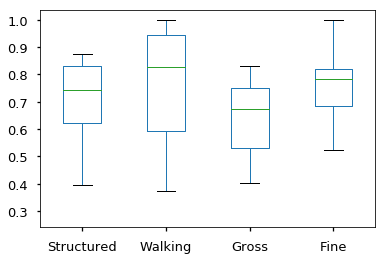

In [110]:
results_task.plot(kind='box')
plt.title('Tremor')

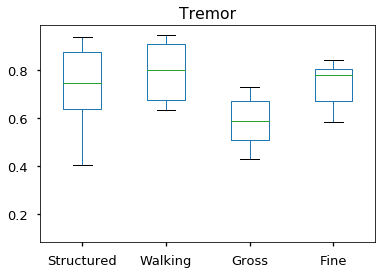

In [147]:
results_task.plot(kind='box')
plt.title('Tremor')